# Week 8 - Clustering

Welcome to the week 8 class notebook! This time, we will focus on clustering. Let's start with the usual imports (more will come later).

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1 - KMeans clustering

Let's use the dataset we prepared recently. 

In [3]:
f=pd.read_csv("NYC_taxis_weather_2016_with_dummies.csv")

How about the following idea: We have many days of data, and would like to see if they form some kind of recognizable patterns (like having days of Type A, or Type B, that follow some visually understandable pattern). 

In other words, the vector that we want to use for clustering will be correspond to each individual day. So, we need to transform our dataframe such that we end up with each row corresponding to a day (and each columns corresponding to a time period - remember that we used 15 minutes before, so let's keep it).

The first thing to do then is the usual datetime format conversions. We also need to extract the actual day ("date"), because that will later become the index... 

In [4]:
f['datetime']=pd.to_datetime(f['datetime'], format="%Y-%m-%d %H:%M:%S")
f=f.set_index('datetime')
f['date']=np.array([d.date() for d in f.index])


We need to have a SINGLE row for each day, and this is the best way to do it:

In [5]:
grouped=list(set(f['date']))  #transforms f['date'], a series of days WITH repetitions, into a set. Then we convert it back to
# a list WITHOUT repititions. To understand this, just check the original value of f['date'], and the output set(f['date'])

Ok, now we have the days that we want. Now, for each day, we want a vector with the sequence of pickups (by 15 min slots).

In [6]:
days={}
for g in grouped:
    day_ts=np.array(f[f.date==g]['pickups1'])
    days[g]=day_ts

check the content of the dictionary days, feel free to play with the code above!

Time to convert that dictionary into our dataframe (Verify by yourself how it works - check the value of d and dt... ): 

In [7]:
d=pd.DataFrame(days)
dt=d.transpose()

Time for our KMeans clustering

In [8]:
from sklearn.cluster import KMeans

We want K=8, but that's just an idea... do try others... 

In [9]:
K=8
k=KMeans(K)

You actually run the KMeans algorithm with the .fit method

In [11]:
k.fit(dt,dt.index);

Let's visualize the centroids!

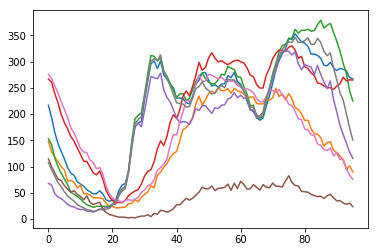

In [12]:
#the object cluster_centers_ is the list of cluster centroids obtained

x=range(96)
for c in k.cluster_centers_:
    plt.plot(x, c)
    

A useful thing is to assign each actual day, to a corresponding cluster

In [13]:
dt_clusters=dt.copy()

In [14]:
dt_clusters['cluster']=k.fit_predict(dt)

Check the **dt_clusters** dataframe

The index column has no name, which will create problems later. It's a date, so let's correct that.

In [15]:
dt_clusters.index.names=['date']

Wanna check?

Cool, now the interesting thing will be to look into the clusters. In other words, what characterizes each one?

Can you check if there is any relationship between clusters and precipitation (prcp)? Any cluster that you'd say "oh, when it rains/snows, the pattern is usually this one"? 

Check with other variables (follow your curiosity)

Change the value of K. Are the conclusions different?

## Part 2 - Density Based clustering - DBScan

And now, for something completely different...

Density based clustering gives completely different results. And in general, it doesn't make much sense to do it above 2 dimensional settings, i.e. have a spacial notion (the one above was _temporal_). 

So, let's play with the 2-D world. For a start, we will generate the data ourselves.

In [16]:
from sklearn.cluster import DBSCAN
import random

We're creating 5 different bivariate gaussians (each one has a 2-D mean, and a covariance matrix). We're generating 500 points, from each such Gaussian.

Feel free to change any of the numbers, and see what happens! 

In [17]:
biv_means=[(5,5), (13, 10), (16, 7), (20, 5), (22, 15)]
biv_covs=[[[1,0.5], [0.5, 1]], [[10,0], [0, 2]], [[3, 0], [0, 7]], [[7, 0.3], [.3, 3]], [[2, 0.5], [.5, 2]]]
N=1000

In [18]:
samples=[np.random.multivariate_normal(mean, cov, N) for mean, cov in zip(biv_means, biv_covs)]
points=np.concatenate(samples)

We want to visualize, so we need to get the x and y dimensions (for the scatter plot)

In [19]:
x_points=points[:, 0]
y_points=points[:, 1]

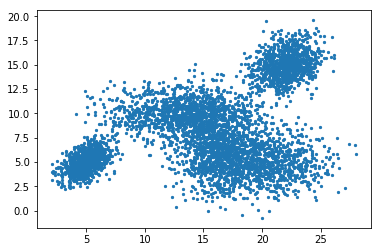

In [20]:
plt.scatter(x_points,y_points, s=5)

Ok, so there are 5 gaussians, that together look like a bunch of "blobs" mixed together... 

We want to extract their corresponding clusters (a cluster is like an homogeneous "blob")

In [21]:
dbs=DBSCAN(min_samples=40, eps=1)

We have created the DBSCAN object. Feel free to change the parameters!

### Part 2a

Let's run the DBSCAN algorithm then...

In [22]:
dbs.fit(points)

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=40, n_jobs=1, p=None)

Inspect the dbs object. For example, check 

> dbs.components_   #the list of points you gave the algorithm

> dbs.labels_   #the label (cluster) associated to each such point  (when you see a -1, it means the point is an outlier)

Just to see the different clusters, as found by DBSCAN, let's associate each one with a different color (the pick of each color is random, because we don't really care about the specific choice). 

In [23]:
import random
from matplotlib import colors as mcolors

num_colors=len(set(dbs.labels_))-1   #it's the number of different labels except for 1 (the -1 label)
colors=list(mcolors.CSS4_COLORS.keys())  #found this by searching "python color list"

Let's randomly choose the colors, then. 

In [24]:
cluster_colors=random.choices(colors, k=num_colors)

Let's plot it

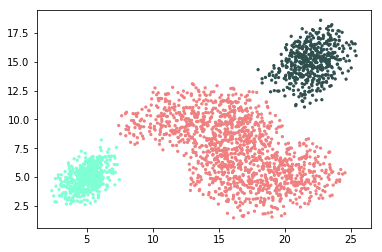

In [304]:
#plt.scatter(f_points['pickup_longitude'], f_points['pickup_latitude'], s=0.01);

x_=[]
y_=[]
c_=[]
for label, x, y in zip(dbs.labels_, x_points, y_points):
    if label==-1:
        continue
    x_.append(x)
    y_.append(y)
    c_.append(cluster_colors[label])
#plt.figure(figsize=(18, 12))
plt.scatter(x_,y_,s=5,c=c_)

    
    

### Part 2b

Ok, so now let's try to compare DBSCAN with KMEans with this dataset. 

Please run KMeans algorithm on it and plot the centroids (if you have time, you can try to assign colors to the points too). 

### Part 2c


Now, for something real. Open the file "PickUps_June_2016_Brooklyn.csv"

In [322]:
f_points=pd.read_csv("PickUps_June_2016_Brooklyn.csv")[:80000]  #We restrict to the first 80k datapoints so that DBSCAN 
                                                                #doesn't take too long on your computer. Feel free to 
                                                                #run the full dataset. You may have to wait...tinsi        

You'll notice that it corresponds to GPS coordinates of all taxi pickups in Brooklyn, during June 2016. 

We want you to find the DBSCAN clusters in this dataset (in practice, the locations where taxis tend to pickup people).


Given your analysis, where would you put taxi stands?